Notebook used by Vicent to create the different clusters

In [1]:

import cugraph
import cudf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import faiss
import anndata
import pandas as pd

In [2]:
cugraph.__version__


'23.12.00'

In [3]:
df = pd.read_csv("v_gene_tcr_filelist.tar.xz", compression='xz', header=0, sep=',').dropna(how="all", axis=0)
patient_columns = [c for c in df.columns if c.startswith("P")]

/tmp/ipykernel_69943/2912372654.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,2

In [4]:
import re
pat = re.compile(r"(TCRBV[0-9-]+)([A-Z]+)")
df[['v_call', 'junction_aa']] = df["combined"].str.extract(pat)

In [5]:
X = df[patient_columns].to_numpy().astype(int)
patients = df[patient_columns].columns.to_numpy()
clonotypes = df[["junction_aa", "v_call"]].to_numpy()

In [6]:
K_NN = 100

In [7]:
X = np.ascontiguousarray(X).astype(np.float32)
X = X-X.mean(axis=1)[:,None]  # Center the rows. Use for adjusted cosine = approx pearson correlation. 
faiss.normalize_L2(X) # L2 normalize counts so that they sum up to one so that cosine similarity is measured (even though we use a dot product index)

In [8]:
idx = faiss.IndexFlatIP(X.shape[1]) # Inner product index
idx.add(X)

In [9]:
D,I = idx.search(X, K_NN)

In [10]:
D.tofile("D.npy")
I.tofile("I.npy")

In [11]:
edgelist = set()
recursive_edgelist = []

for s,t,sim in zip(
    np.repeat(np.arange(I.shape[0]), K_NN).astype(int), #source
    I[:,:K_NN].ravel(),      #target
    D[:,:K_NN].ravel()):     #distance
        t = int(t)
        if s<t:
            edgelist.add((s,t))
        if t<s:
            if (t,s) in edgelist:
                recursive_edgelist.append((s,t,sim))

del edgelist

In [13]:
source, target, similarity = zip(*recursive_edgelist)

edge_df = cudf.DataFrame({
    "source":source,
    "target":target,
    "weight":similarity

})

edge_df.source = edge_df.source.astype(np.int32)
edge_df.target = edge_df.target.astype(np.int32)

In [14]:
G = cugraph.from_cudf_edgelist(edge_df, source="source", destination="target", edge_attr="weight") # create weighted graph object

In [199]:
# scl = cugraph.spectralModularityMaximizationClustering(G, num_clusters=1000, num_eigen_vects=50)
cl, score = cugraph.leiden(G, resolution=8, theta=0.3)
cl = cl.to_pandas()


In [207]:
cl["partition"].nunique()

4333

Text(0.5, 0, 'Module size')

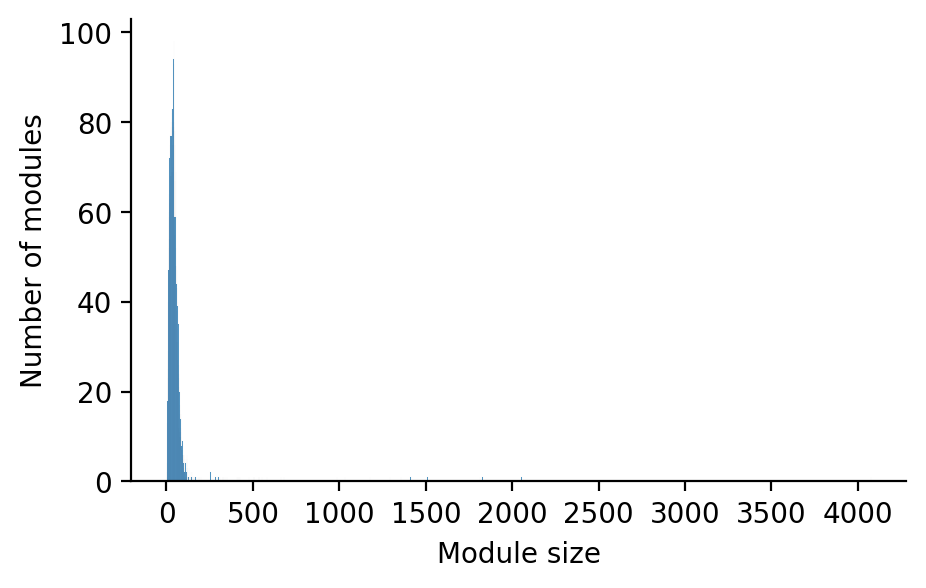

In [201]:
fig, ax = plt.subplots(figsize=(5,3),dpi=200)
sizes = cl["partition"].value_counts().to_numpy()
sns.histplot(sizes, binwidth=1)
sns.despine()
ax.set_ylabel("Number of modules")
ax.set_xlabel("Module size")

# ax.set_xscale("log")

In [210]:
cl.sort_values("vertex", inplace=True)
cl[["junction_aa", "v_call"]] = clonotypes[cl["vertex"].to_numpy()]
cl.to_csv("clustering.csv", index=False)